## BC COVID-19 Visualizations

### Import libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

### Import data

In [2]:
confirmed_df = pd.read_csv('data/confirmed.csv') 

### Set regions

In [3]:
region_list = ['VancouverCoastal', 'Fraser', 'Island', 'Interior', 'Northern']
region_list_daily = ['VancouverCoastal_daily', 'Fraser_daily', 'Island_daily', 'Interior_daily', 'Northern_daily']

### Calculate daily cases

In [4]:
def calculate_daily_cases(region):
    daily_region_cases = '{}_daily'.format(region)
    confirmed_df.loc[0, daily_region_cases] = confirmed_df.loc[0, region]
    for i in range(1, len(confirmed_df)):
        daily_region_case = confirmed_df.loc[i, region] - confirmed_df.loc[i-1, region]
        confirmed_df.loc[i, daily_region_cases] = daily_region_case

for region in region_list:
    calculate_daily_cases(region)

### Calculate total cases

In [5]:
confirmed_df['total'] = confirmed_df[region_list].sum(axis=1)
confirmed_df['total_daily'] = confirmed_df[region_list_daily].sum(axis=1)

### Define plotting methods

In [6]:
def plot_cases(useLog=False):
    cases_plot = confirmed_df['total']
    title = '# of Confirmed Cases in BC'
    if useLog:
        cases_plot = np.log1p(cases_plot)
        title = 'Log of # of Confirmed Cases in BC'
    plt.figure(figsize=(9, 5))
    plt.plot(confirmed_df['DayCount'], cases_plot)
    plt.title(title, size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel('# of Cases', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
def plot_daily_increases():
    plt.figure(figsize=(9, 5))
    plt.bar(confirmed_df['DayCount'], confirmed_df['total_daily'])
    plt.title('Daily Increases in Confirmed Cases', size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel('# of Cases', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
def plot_cases_by_region_line(useLog=False):
    plt.figure(figsize=(9, 5))
    for region in region_list:
        case_plot = confirmed_df[region]
        if useLog:
            case_plot = np.log1p(case_plot)
        plt.plot(confirmed_df['DayCount'], case_plot)
    title = '# of Confirmed Cases in BC by Region'
    if useLog:
        title = 'Log of # of Confirmed Cases in BC by Region'
    plt.title(title, size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel('# of Cases', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.legend(region_list, prop={'size': 12})
    plt.show()
    
def plot_cases_by_region_bar(daily=False):
    most_recent_cases = confirmed_df.iloc[[-1]]
    regions = region_list
    title = 'Total Confirmed Cases by Health Region'
    if daily:
        regions = region_list_daily
        title = 'Total Confirmed Cases by Health Region {}'.format(most_recent_cases['Date'].values[0])
    total_recent_cases = most_recent_cases[regions].values[0].astype(int)
    fig, ax = plt.subplots()    
    width = 0.75
    ind = np.arange(len(total_recent_cases))
    ax.barh(ind, total_recent_cases, width)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(regions, minor=False)
    for i, v in enumerate(total_recent_cases):
        ax.text(v + 3, i + .25, str(v))
    plt.title(title)
    plt.xlabel('Number of Cases')
    plt.ylabel('Health Region')
    plt.show()
    
def plot_daily_increases_vs_total_confirmed(useLog=False):
    plt.figure(figsize=(9, 5))
    total_plot = confirmed_df['total']
    daily_plot = confirmed_df['total_daily']
    if useLog:
        total_plot = np.log1p(total_plot)
        daily_plot = np.log1p(daily_plot)
    plt.plot(total_plot, daily_plot)
    title = 'Daily Increases vs Total Confirmed Cases'
    xLabel = '# of Total Cases Confirmed'
    yLabel = '# of New Daily Cases Confirmed'
    if useLog:
        xLabel = 'Log of # of Total Cases Confirmed'
        yLabel = 'Log of # of New Daily Cases Confirmed'
        title = 'Log of Daily Increases vs Total Confirmed Cases'
    plt.title(title, size=12)
    plt.xlabel('# of Total Cases Confirmed', size=12)
    plt.ylabel('# of New Daily Cases Confirmed', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

### Plot total confirmed cases

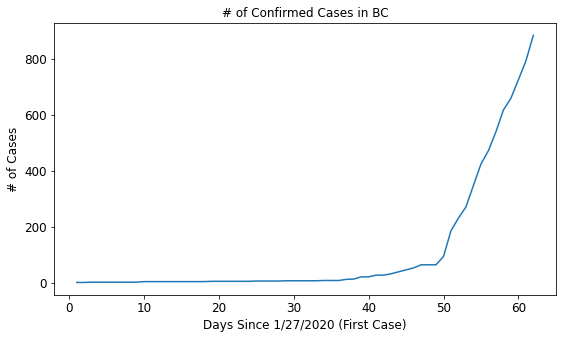

In [7]:
plot_cases()

### Plot log of total # of confirmed cases

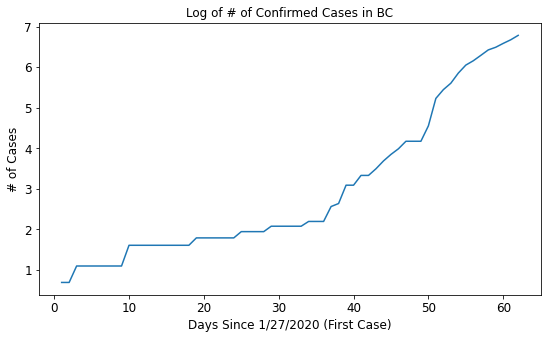

In [8]:
plot_cases(useLog=True)

### Plot Daily Increases

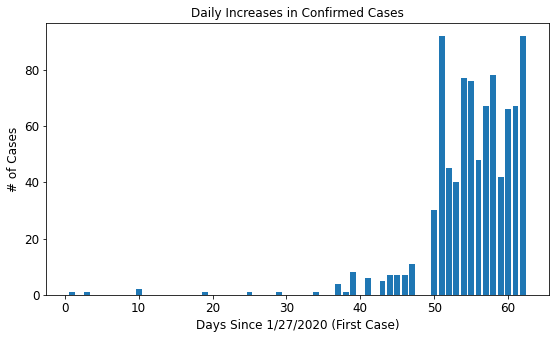

In [9]:
plot_daily_increases()

### Plot total confirmed cases by region

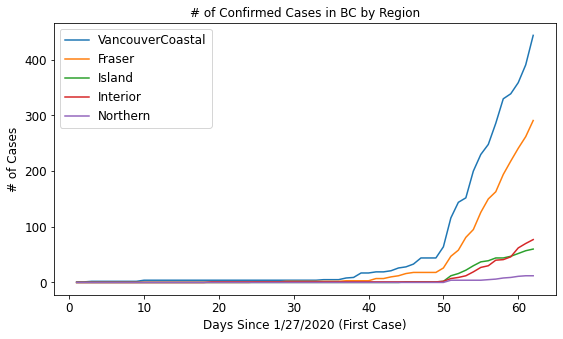

In [10]:
plot_cases_by_region_line()

### Plot log of total confirmed cases by region

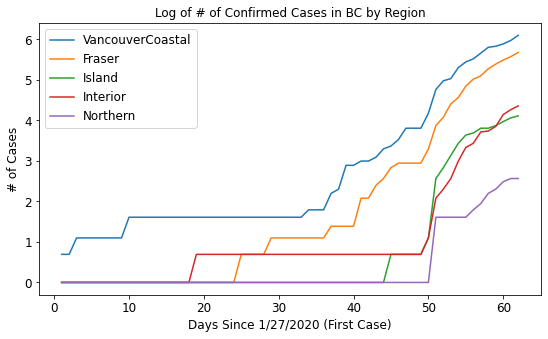

In [11]:
plot_cases_by_region_line(useLog=True)

### Plot cumulative cases by region

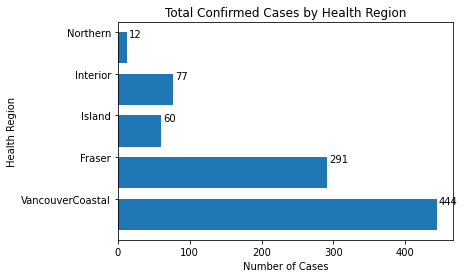

In [12]:
plot_cases_by_region_bar()

### Plot most recent day confirmed cases by region

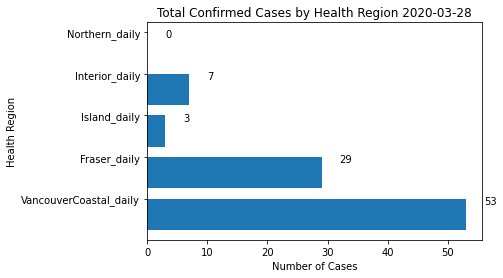

In [13]:
plot_cases_by_region_bar(daily=True)

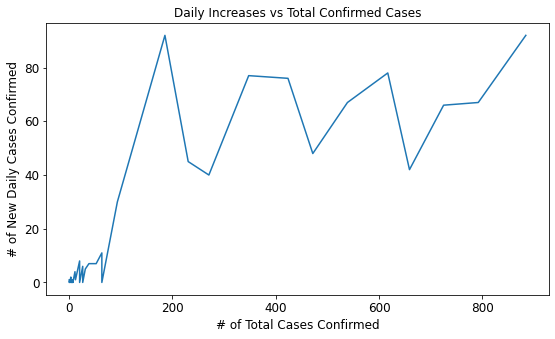

In [14]:
plot_daily_increases_vs_total_confirmed()

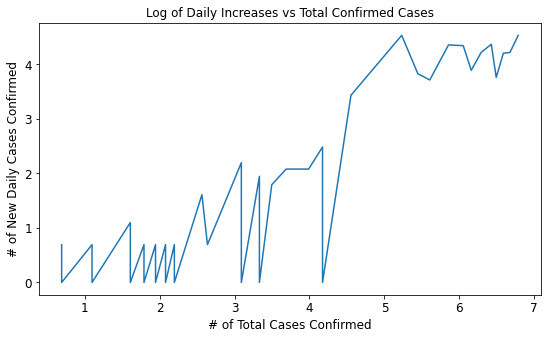

In [15]:
plot_daily_increases_vs_total_confirmed(useLog=True)